In [23]:
# Necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download zip 
from io import StringIO, BytesIO, TextIOWrapper
from zipfile import ZipFile
import urllib

#warnings
import warnings
warnings.filterwarnings("ignore")

#text cleaning
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder

#model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

#metrics
from sklearn.metrics import accuracy_score

#save file
import pickle

In [2]:
# https://files.consumerfinance.gov/ccdb/complaints.csv.zip

cf_url = "https://files.consumerfinance.gov/ccdb/"
complaints_zip = "complaints.csv.zip"
resp = urllib.request.urlopen(cf_url +  urllib.request.quote(complaints_zip))

zipfile = ZipFile(BytesIO(resp.read()))
data = TextIOWrapper(zipfile.open('complaints.csv'), encoding='utf-8')

df = pd.read_csv(data)

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-04-29,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,Experian Information Solutions Inc.,FL,33326.0,NaN,NaN,Web,2022-04-29,In progress,Yes,NaN,5518042
1,2022-04-29,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,76015.0,NaN,NaN,Web,2022-04-29,Closed with non-monetary relief,Yes,NaN,5516818
2,2022-04-24,Debt collection,I do not know,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,PORTFOLIO RECOVERY ASSOCIATES INC,PA,19063.0,NaN,NaN,Web,2022-04-24,Closed with explanation,Yes,NaN,5488290
3,2022-04-29,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,SC,29624.0,Older American,NaN,Web,2022-04-29,Closed with non-monetary relief,Yes,NaN,5516030
4,2022-04-29,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,GA,30022.0,NaN,Consent not provided,Web,2022-04-29,Closed with explanation,Yes,NaN,5517155


In [4]:
df.shape

(2657859, 18)

In [5]:
df_complaints = df[['Product', 'Consumer complaint narrative']].copy()
df_complaints.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,"Credit reporting, credit repair services, or o...",NaN
2,Debt collection,NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,"Credit reporting, credit repair services, or o...",NaN


In [6]:
df_complaints.isnull().sum()

Product                               0
Consumer complaint narrative    1729467
dtype: int64

In [7]:
df_complaints.dropna(subset=['Consumer complaint narrative'], axis=0, inplace = True)

In [8]:
df_complaints.shape

(928392, 2)

In [9]:
df_complaints.rename(columns={'Product': 'products', 'Consumer complaint narrative': 'complaints'}, inplace=True)

In [10]:
df_complaints.reset_index(drop=True, inplace=True)
df_complaints.head()

,products,complaints
0,Credit card or prepaid card,It should be illegal. I havent use my credit c...
1,Debt collection,As of XX/XX/XXXX I have yet to receive anythin...
2,"Credit reporting, credit repair services, or o...",I have been a Kohls credit card holder for ove...
3,Credit card or prepaid card,"Please reopen case XXXX, Nothing has been reso..."
4,Checking or savings account,Banking services or operating as expected. Sun...


In [11]:
df_complaints.products.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    384887
Debt collection                                                                 175207
Mortgage                                                                         91352
Credit card or prepaid card                                                      70465
Checking or savings account                                                      44658
Credit reporting                                                                 31588
Student loan                                                                     30623
Money transfer, virtual currency, or money service                               22152
Credit card                                                                      18838
Vehicle loan or lease                                                            17422
Bank account or service                                                          14885
Payday loan, title loan, or personal loan  

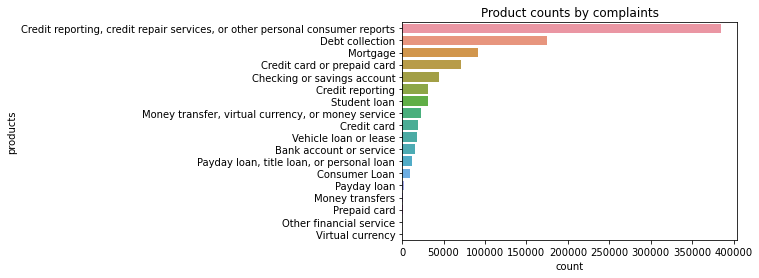

In [14]:
sns.countplot(order=df_complaints.products.value_counts().index, y=df_complaints.products, data=df_complaints)
plt.title('Product counts by complaints')
plt.show()

In [15]:
#Removing duplicates
df_complaints.duplicated().sum()

103507

In [16]:
df_complaints.drop_duplicates(inplace=True)

In [17]:
df_complaints.products.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    294313
Debt collection                                                                 166297
Mortgage                                                                         91222
Credit card or prepaid card                                                      69295
Checking or savings account                                                      44606
Student loan                                                                     30480
Credit reporting                                                                 29827
Money transfer, virtual currency, or money service                               21867
Credit card                                                                      18757
Vehicle loan or lease                                                            17141
Bank account or service                                                          14856
Payday loan, title loan, or personal loan  

In [18]:
#Removing aggregated products
df_complaints.drop(df_complaints[df_complaints.products == 'Credit reporting, credit repair services, or other personal consumer reports'].index, inplace=True)
df_complaints.drop(df_complaints[df_complaints.products == 'Money transfer, virtual currency, or money service'].index, inplace=True)
df_complaints.drop(df_complaints[df_complaints.products == 'Payday loan, title loan, or personal loan'].index, inplace=True)
df_complaints.drop(df_complaints[df_complaints.products == 'Credit card or prepaid card'].index, inplace=True)
df_complaints.products.value_counts()

Debt collection                166297
Mortgage                        91222
Checking or savings account     44606
Student loan                    30480
Credit reporting                29827
Credit card                     18757
Vehicle loan or lease           17141
Bank account or service         14856
Consumer Loan                    9439
Payday loan                      1740
Money transfers                  1496
Prepaid card                     1448
Other financial service           291
Virtual currency                   14
Name: products, dtype: int64

In [19]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427614 entries, 1 to 928390
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   products    427614 non-null  object
 1   complaints  427614 non-null  object
dtypes: object(2)
memory usage: 9.8+ MB


In [20]:
## Combining Loans together to make this a simplier classification problem

df_complaints.replace('Student loan', 'Loan', inplace=True)
df_complaints.replace('Consumer Loan', 'Loan', inplace=True)
df_complaints.replace('Payday loan', 'Loan', inplace=True)
df_complaints.replace('Vehicle loan or lease', 'Loan', inplace=True)

# Placing Virtual currency into other financial service
df_complaints.replace('Virtual currency', 'other services', inplace=True)
df_complaints.replace("Other financial service", 'other services', inplace=True)

df_complaints.replace('Checking or savings account', 'savings account', inplace=True)
df_complaints.replace('Bank account or service', 'savings account', inplace=True)

In [21]:
df_complaints.products.value_counts()

Debt collection     166297
Mortgage             91222
savings account      59462
Loan                 58800
Credit reporting     29827
Credit card          18757
Money transfers       1496
Prepaid card          1448
other services         305
Name: products, dtype: int64

In [22]:
df_complaints.head()

,products,complaints
1,Debt collection,As of XX/XX/XXXX I have yet to receive anythin...
4,savings account,Banking services or operating as expected. Sun...
6,Debt collection,I have not received information to verify this...
7,savings account,I used Credit Karma ( CK ) tax to file my taxe...
15,Loan,Kia Finance is showing I have a {$10.00} curre...


In [24]:
pickle.dump(df_complaints, open('df_complaints.pkl', 'wb'))

In [32]:
def reduce_product(product):
    #considering only the first 1000 records from each product for a balance in dataset
    df_reduced = df_complaints[df_complaints.products == product].head(1000)
    return df_reduced

In [33]:
values = df_complaints.products.unique()
values

array(['Debt collection', 'savings account', 'Loan', 'Mortgage',
       'Credit reporting', 'Credit card', 'other services',
       'Money transfers', 'Prepaid card'], dtype=object)

In [35]:
df_filtered = pd.DataFrame()
for product in values:
    df_filtered = df_filtered.append(reduce_product(product))

In [36]:
df_filtered.head()

,products,complaints
1,Debt collection,As of XX/XX/XXXX I have yet to receive anythin...
6,Debt collection,I have not received information to verify this...
18,Debt collection,This agency has been harassing to pay a debt t...
24,Debt collection,I wrote a letter to AR Resources about a medic...
29,Debt collection,XX/XX/2022. The debt collection agency contact...


In [37]:
df_filtered.products.value_counts()

Debt collection     1000
savings account     1000
Loan                1000
Mortgage            1000
Credit reporting    1000
Credit card         1000
Money transfers     1000
Prepaid card        1000
other services       305
Name: products, dtype: int64

In [38]:
le = LabelEncoder()
df_filtered['product_id'] = le.fit_transform(df_filtered.products)

In [40]:
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.head()

,products,complaints,product_id
0,Debt collection,As of XX/XX/XXXX I have yet to receive anythin...,2
1,Debt collection,I have not received information to verify this...,2
2,Debt collection,This agency has been harassing to pay a debt t...,2
3,Debt collection,I wrote a letter to AR Resources about a medic...,2
4,Debt collection,XX/XX/2022. The debt collection agency contact...,2


In [41]:
df_transformed = df_filtered[['product_id', 'complaints']].copy()
df_transformed.head()

,product_id,complaints
0,2,As of XX/XX/XXXX I have yet to receive anythin...
1,2,I have not received information to verify this...
2,2,This agency has been harassing to pay a debt t...
3,2,I wrote a letter to AR Resources about a medic...
4,2,XX/XX/2022. The debt collection agency contact...


In [42]:
ps = PorterStemmer()
def clean_text(series):
    series = series.apply(lambda x: re.sub('[^a-zA-Z]|[XX*]', ' ', x).split())
    series = series.apply(lambda x: [ps.stem(i) for i in x])
    series = series.apply(lambda x: ' '.join(x))
    return series

In [43]:
df_transformed['complaints'] = clean_text(df_transformed['complaints'])

In [44]:
df_transformed.head()

,product_id,complaints
0,2,as of i have yet to receiv anyth to valid said...
1,2,i have not receiv inform to verifi thi debt
2,2,thi agenc ha been harass to pay a debt that ha...
3,2,i wrote a letter to ar resourc about a medic b...
4,2,the debt collect agenc contact my brother in a...


In [48]:
X = df_transformed.drop(['product_id'], axis=1)
y = df_transformed['product_id']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X_train.head()

,complaints
4319,after appli for credit sever month ago i wa de...
2580,in my incom sensit payment program wa approach...
478,i got a voic email state my warrant number and...
1352,usa citibank start onc again deleg transact fr...
3322,i appli for a mortgag loan on through freedom ...


In [51]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [53]:
cv = CountVectorizer(max_features=1000, ngram_range=(1,3), stop_words='english')
tfidf = TfidfTransformer()

In [54]:
X_train1 = cv.fit_transform(X_train['complaints'])
X_train1 = tfidf.fit_transform(X_train1).toarray()

In [55]:
X_train1.shape

(6644, 1000)

In [56]:
X_test1 = cv.fit_transform(X_test['complaints'])
X_test1 = tfidf.fit_transform(X_test1).toarray()

In [57]:
X_test1.shape

(1661, 1000)

In [58]:
mnb = MultinomialNB()
mnb.fit(X_train1, y_train)
mnb_predictions = mnb.predict(X_test1)

In [59]:
accuracy_score(y_test, mnb_predictions)

0.2913907284768212

In [60]:
X_test1

array([[0.        , 0.        , 0.44142636, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05927065, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02233021, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [61]:
X1 = cv.fit_transform(df_transformed['complaints'])
X1 = tfidf.fit_transform(X1).toarray()

In [62]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y, test_size=0.2, random_state=42)

In [63]:
mnb1 = MultinomialNB()
mnb1.fit(X_train2, y_train2)
mnb1_predictions = mnb1.predict(X_test2)

In [64]:
accuracy_score(y_test2, mnb1_predictions)

0.7874774232390126

In [65]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train2, y_train2)
rfc_predictions = rfc.predict(X_test2)

In [66]:
accuracy_score(y_test2, rfc_predictions)

0.7959060806742926

In [67]:
lr = LogisticRegression()
lr.fit(X_train2, y_train2)
lr_predictions = lr.predict(X_test2)

In [68]:
accuracy_score(y_test2, lr_predictions)

0.8236002408187839

In [69]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb1.fit(X_train2, y_train2)
xgb1_predictions = xgb1.predict(X_test2)

[22:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [70]:
accuracy_score(y_test2, xgb1_predictions)

0.8290186634557496